In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("train.csv", sep=",")
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
43740,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
43741,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
43742,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


## Dataset attributes

- **site_id** - ID code for the source hospital.
- **patient_id** - ID code for the patient.
- **image_id** - ID code for the image.
- **laterality** - Whether the image is of the left (L) or right (R) breast.
- **view** - The orientation of the image. The default for a screening exam is to capture two views per breast.
- **age** - The patient's age in years.
- **cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- **biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- **invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- **BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- **implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- **density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- **machine_id** - An ID code for the imaging device.
- **difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

In [3]:
# Número total de imagens:
print("Número total de imagens: ", df_train["image_id"].count())

# Vamos analisar os números com relação aos hospitais (site_id):
print("Número de diferentes hospitais: ", df_train["site_id"].nunique(), ", cujos códigos são: ", df_train["site_id"].unique())
print("Distribuição de imagens por hospital: ", df_train.groupby("site_id").agg(qtde=("image_id","count")).reset_index())

# Número de pacientes distintos (patient_id):
print("Número de pacientes distintos:" , df_train["patient_id"].nunique())

# Distribuição de imagens com relação a lateralidade (laterality):
print("Número de imagens de seios esquerdos (L) e direitos (R):" , df_train.groupby("laterality").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens com relação a sua orientação (view):
print("Número de imagens em cada orientação:" , df_train.groupby("view").agg(qtde=("image_id","count")).reset_index().sort_values(by="qtde", ascending=False))

# Número de imagens com implante (implant):
print("Número de imagens com e sem implante:" , df_train.groupby("implant").agg(qtde=("image_id","count")).reset_index())

# Número de imagens com e sem Câncer (cancer):
print("Número de imagens com e sem Câncer:" , df_train.groupby("cancer").agg(qtde=("image_id","count")).reset_index())

# Número de imagens positivas para câncer classificadas como invasivas (invasive):
print("Número de imagens positivas para câncer classificadas como invasivas:" , df_train[df_train["cancer"]==1].groupby("invasive").agg(qtde=("image_id","count")).reset_index())

# Número de imagens classificadas como extraordinariamente dificeis (difficult_negative_case):
print("Número de imagens classificadas como extraordinariamente dificeis:" , df_train.groupby("difficult_negative_case").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens de acordo com a densidade do tecido mamário (density):
print("Distribuição de imagens de acordo com a densidade do tecido mamário: ", df_train.groupby("density").agg(qtde=("image_id","count")).reset_index())

# Relação entre diagnósticos de cancer com biópsias (cancer, biopsy):
print("Relação entre diagnósticos de cancer com biópsias: ", df_train.groupby(["cancer", "biopsy"]).agg(qtde=("image_id","count")).reset_index())

Número total de imagens:  43744
Número de diferentes hospitais:  2 , cujos códigos são:  [2 1]
Distribuição de imagens por hospital:     site_id   qtde
0        1  23709
1        2  20035
Número de pacientes distintos: 9530
Número de imagens de seios esquerdos (L) e direitos (R):   laterality   qtde
0          L  21806
1          R  21938
Número de imagens em cada orientação:   view   qtde
5  MLO  22302
1   CC  21413
0   AT     16
4   ML      7
2   LM      5
3  LMO      1
Número de imagens com e sem implante:    implant   qtde
0        0  42587
1        1   1157
Número de imagens com e sem Câncer:    cancer   qtde
0       0  42778
1       1    966
Número de imagens positivas para câncer classificadas como invasivas:    invasive  qtde
0         0   273
1         1   693
Número de imagens classificadas como extraordinariamente dificeis:    difficult_negative_case   qtde
0                    False  37537
1                     True   6207
Distribuição de imagens de acordo com a densidade d

* Pelos números acima, vemos que existe um desbalanceamento enorme para a classe negativa de câncer (97,8%) contra a positiva (2,2%);
* Existem pouquíssimas imagens com implantes (2,65%);
* Mais de 99% das imagens estão orientadas nas posições CC (craniocaudal) e MLO (mediolateral obliquo);
* Há um balanço no número de imagens com relação ao hospital de origem e lado dos seios;
* Identificamos 6207 imagens que estão classificadas como extraordinariamente dificeis;
* Das 966 imagens positivas para câncer, cerca de 40% não são invasivas;
* A distribuição de imagens de acordo com a densidade do tecido mamário tem uma concentração para os níveis B e C (densidades médias);
* No total tivemos 2.442 imagens com biópsias. Todos os casos de cancer positivo tiveram biópsias. Não houve casos de cancer positivo sem biópsia.



In [4]:
# Análise dos campos buscando valores faltantes:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  43744 non-null  int64  
 1   patient_id               43744 non-null  int64  
 2   image_id                 43744 non-null  int64  
 3   laterality               43744 non-null  object 
 4   view                     43744 non-null  object 
 5   age                      43720 non-null  float64
 6   cancer                   43744 non-null  int64  
 7   biopsy                   43744 non-null  int64  
 8   invasive                 43744 non-null  int64  
 9   BIRADS                   20959 non-null  float64
 10  implant                  43744 non-null  int64  
 11  density                  23674 non-null  object 
 12  machine_id               43744 non-null  int64  
 13  difficult_negative_case  43744 non-null  bool   
dtypes: bool(1), float64(2)

Identificamos 3 campos com valores faltantes:
* **age**     - 24 registros nulos. **Sugestão**: Substituir os valores faltantes pela média;
* **BIRADS**  - 22.785 registros nulos (52%). **Sugestão**: O campo está disponível apenas no conjunto de treinamento;
* **density** - 20.070 registros nulos (46%). **Sugestão**: O campo está disponível apenas no conjunto de treinamento;

In [5]:
col_dir = 'train_images/5/'

import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

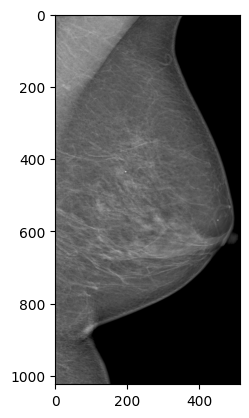

In [21]:
plt.imshow(load_images_from_folder(col_dir)[1], cmap = "jet").set_cmap('jet')